<a href="https://colab.research.google.com/github/K1EH/GCU_DeepLearning/blob/main/07_1109_CreditCard_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Keras의 Autoencoder를 활용해 신용카드 이상 거래 탐지하기https://github.com/KerasKorea/KEKOxTutorial/blob/master/20_Keras%EC%9D%98%20Autoencoder%EB%A5%BC%20%ED%99%9C%EC%9A%A9%ED%95%B4%20%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C%20%EC%9D%B4%EC%83%81%20%EA%B1%B0%EB%9E%98%20%ED%83%90%EC%A7%80%ED%95%98%EA%B8%B0.md

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# 필요한 라이브러리 로드
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

# 시각화 라이브러리 설정
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 202035254
LABELS = ["Normal", "Fraud"]

In [7]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sources/creditcard.csv")

In [8]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [9]:
df.shape

(284807, 31)

In [10]:
df.isnull().values.any()

False

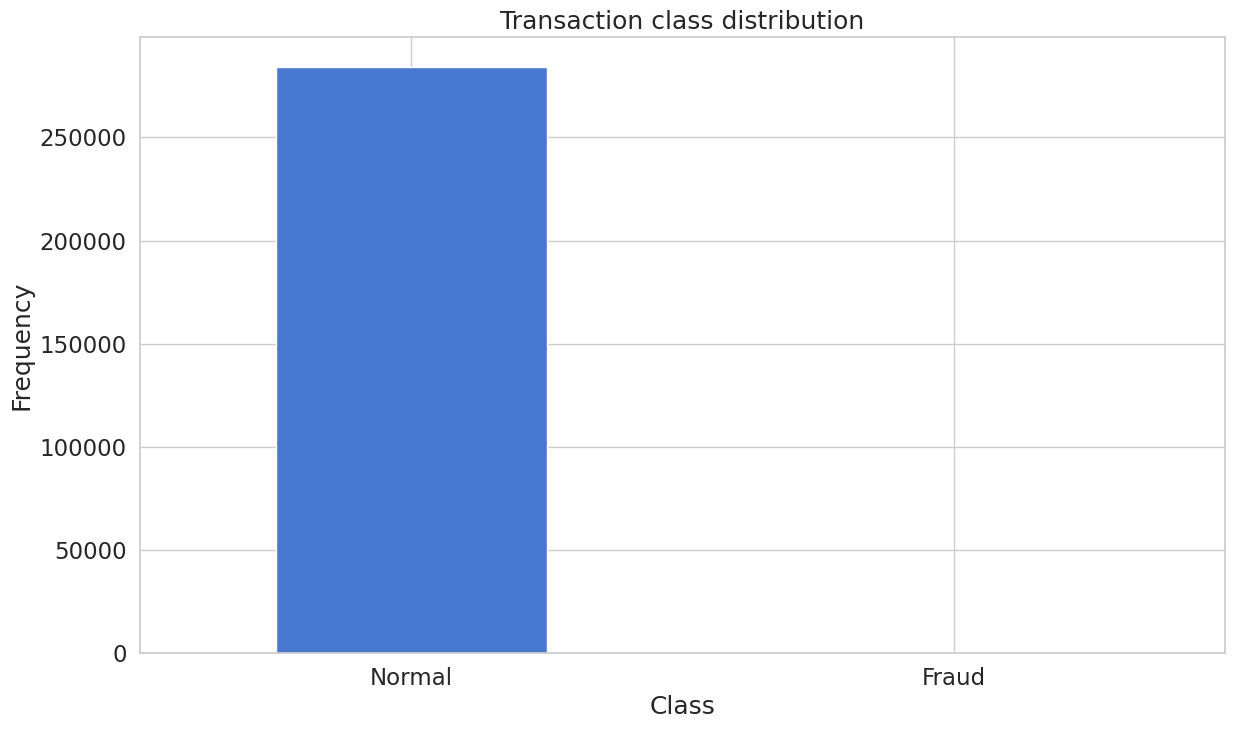

In [11]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

정상 거래가 이상 거래에 비해 압도적으로 많은 불균형적인 데이터를 가지고 있음

### 두 거래 유형에 대해 살펴보기

In [12]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [13]:
normal.shape

(284315, 31)

### 각 거래 유형의 거래액의 다른점

In [14]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [15]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

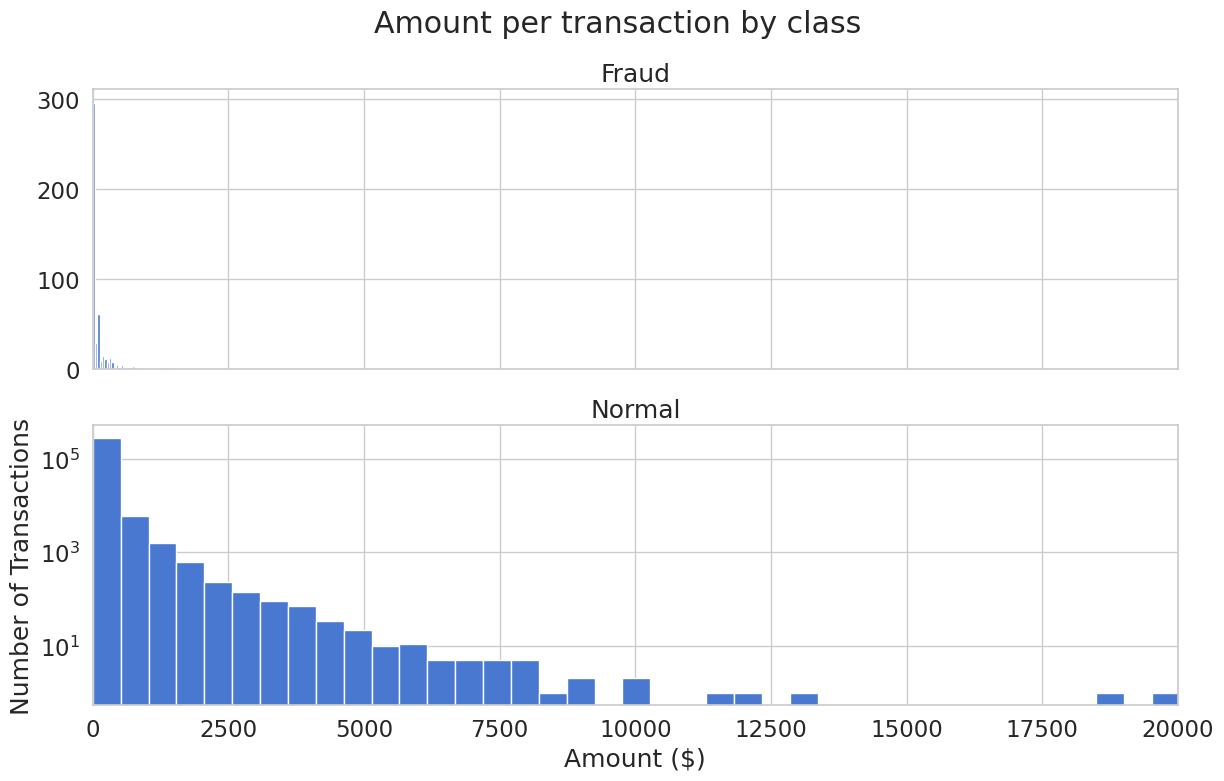

In [16]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

### 이상거래가 특정 시간에 더 자주 발생하는지 살펴보기

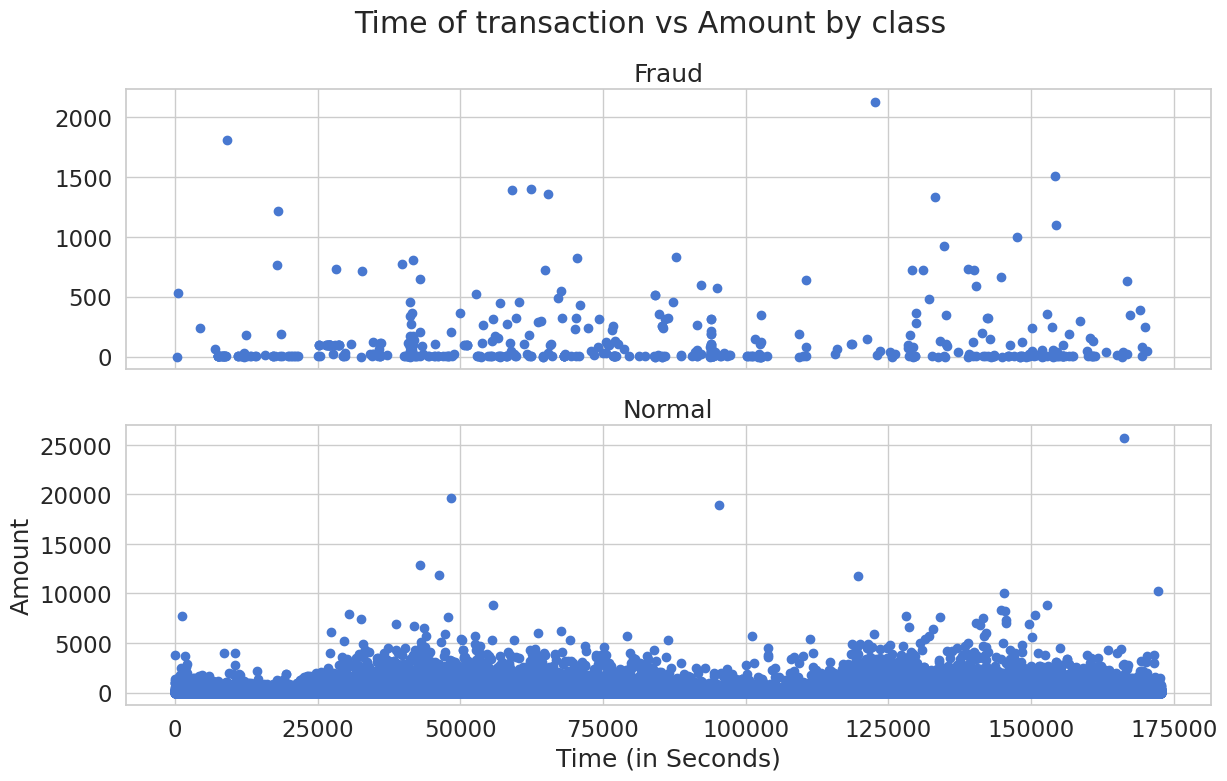

In [17]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

-> 거래가 발생한 시각이 중요해 보이지는 않음

시간 열 삭제 후, Scikit-learn의 StandardScaler를 거래액 열에 적용

StandardScaler는 평균을 제거하고 값들을 단위 분산(unit variance)에 맞게 스케일링해줌

In [18]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

우리가 가진 데이터셋 내에 이상거래가 거의 없다고 가정한 후, 새로운 거래가 발생 했을 때, 이상을 탐지하는 것이 목적임

따라서 모델을 오직 정상 거래기록으로만 훈련시킴

이후, 정상 거래기록을 테스트셋에 넣으면 모델의 성능 평가가 가능

In [19]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(227456, 29)

다음 AutoEncoder는 4개의 fully connected layer로 이루어지고,

각 layer는 14, 7, 7, 29개의 뉴런으로 구성됨

encoding_dim, int(encoding_dim / 2), int(encoding_dim / 2), input_dim

처음 두개의 layer들은 encoder, 뒤의 두개는 decoder이며, L1정규화를 사용

In [20]:
X_train.shape[1]

29

In [21]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

100개의 epoch동안 32개의 batch_size로 훈련시킨 후, 가장 우수한 성능을 가진 모델을 파일로 저장할 것

In [22]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model_credit.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7108/7108 [==============================] - 25s 3ms/step - loss: 0.7900 - accuracy: 0.5856 - val_loss: 0.8215 - val_accuracy: 0.6628
Epoch 2/100
  41/7108 [..............................] - ETA: 18s - loss: 0.7659 - accuracy: 0.6532

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7108/7108 [==============================] - 21s 3ms/step - loss: 0.7199 - accuracy: 0.6713 - val_loss: 0.8007 - val_accuracy: 0.6852
Epoch 3/100
7108/7108 [==============================] - 26s 4ms/step - loss: 0.7083 - accuracy: 0.6864 - val_loss: 0.7934 - val_accuracy: 0.6913
Epoch 4/100
7108/7108 [==============================] - 24s 3ms/step - loss: 0.7040 - accuracy: 0.6932 - val_loss: 0.7908 - val_accuracy: 0.6891
Epoch 5/100
7108/7108 [==============================] - 21s 3ms/step - loss: 0.7007 - accuracy: 0.6993 - val_loss: 0.7871 - val_accuracy: 0.7081
Epoch 6/100
7108/7108 [==============================] - 24s 3ms/step - loss: 0.6979 - accuracy: 0.7065 - val_loss: 0.7822 - val_accuracy: 0.7125
Epoch 7/100
7108/7108 [==============================] - 20s 3ms/step - loss: 0.6954 - accuracy: 0.7127 - val_loss: 0.7806 - val_accuracy: 0.7177
Epoch 8/100
7108/7108 [==============================] - 23s 3ms/step - loss: 0.6934 - accuracy: 0.7173 - val_loss: 0.7766 - val_accurac

In [30]:
autoencoder = load_model('model_credit.h5')

# 평가하기

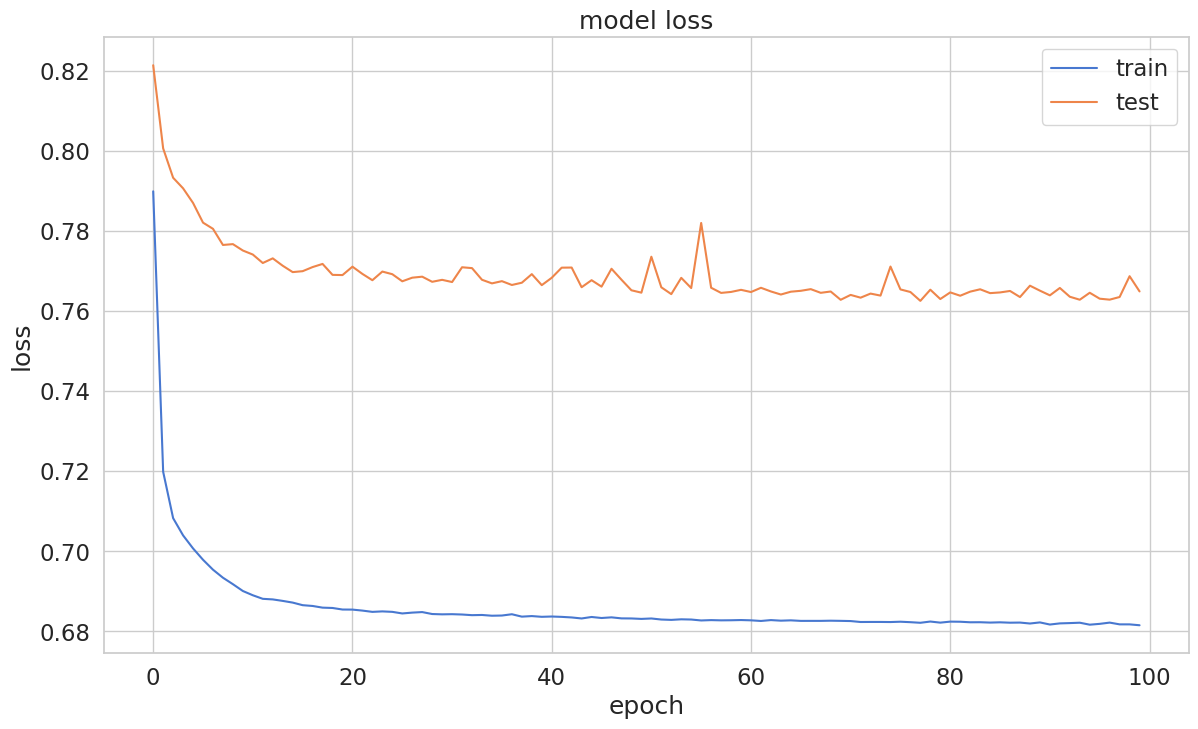

In [31]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

training data와 test data에 대한 재구성 오류가 잘 수렴하는 것처럼 보임

아래에서, 오류 분포에 대해 더 살펴봄

In [32]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

1781/1781 [==============================] - 8s 4ms/step


,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.761785,0.001808
std,7.781437,0.042485
min,0.040726,0.000000
25%,0.236774,0.000000
50%,0.383995,0.000000
75%,0.626417,0.000000
max,1592.384064,1.000000


### 정상 거래 데이터들의 재구성 오류 분포

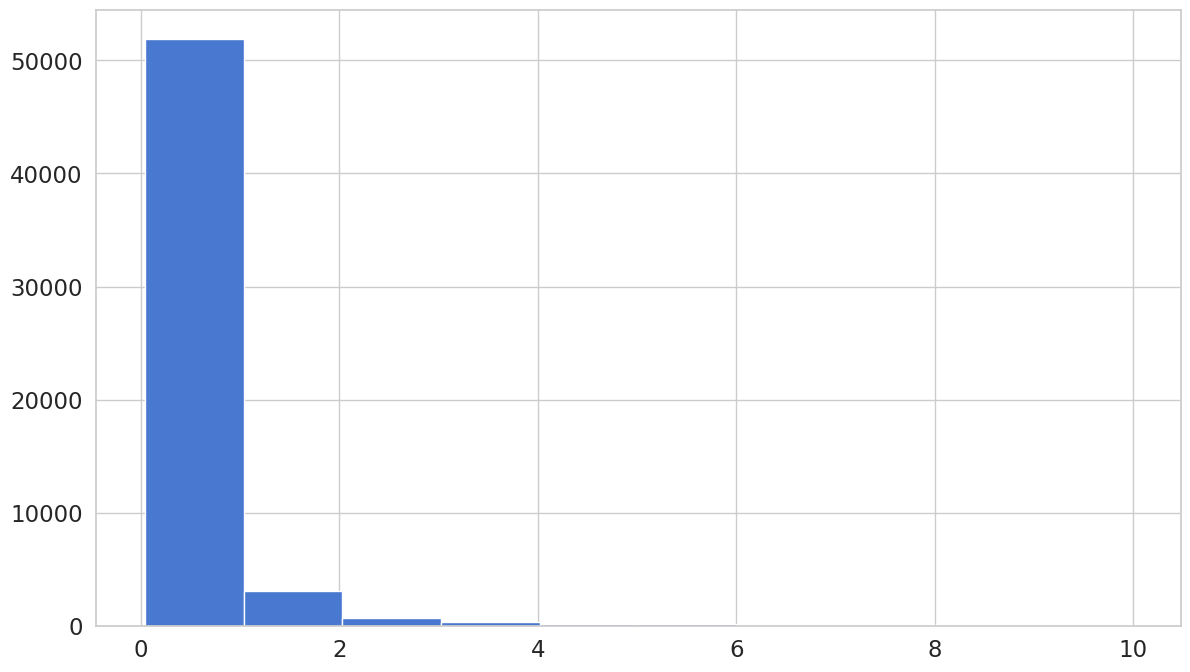

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)### 정상 거래 데이터들의 재구성 오류 분포

### 이상 거래 데이터들의 재구성 오류 분포

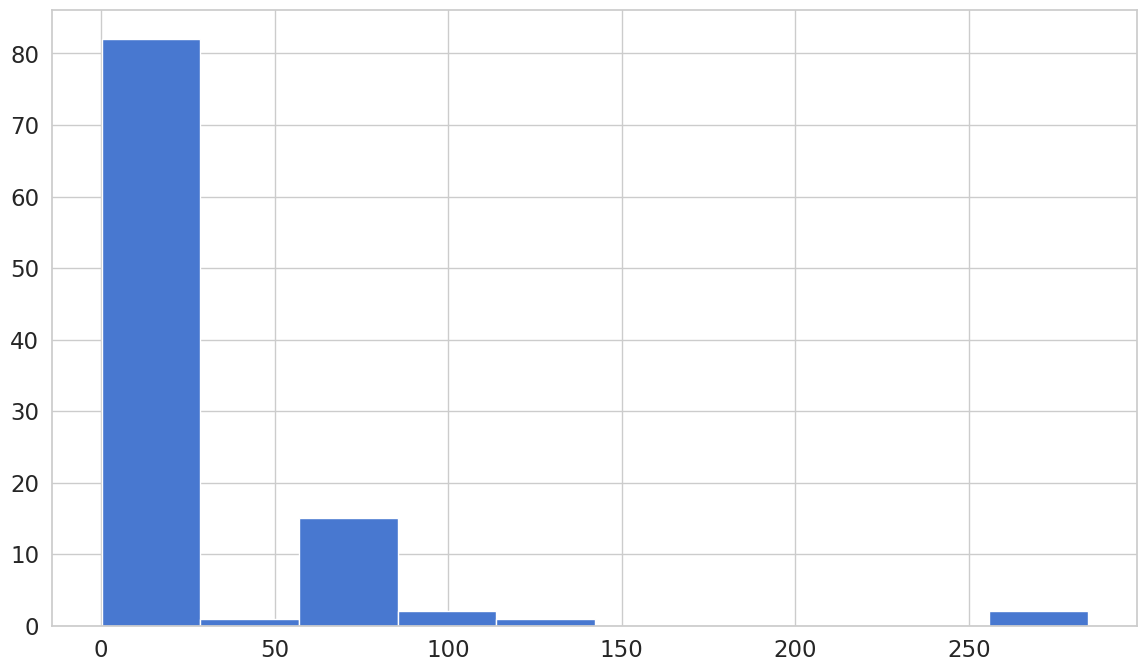

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

### ROC 곡선을 통한 평가

In [35]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

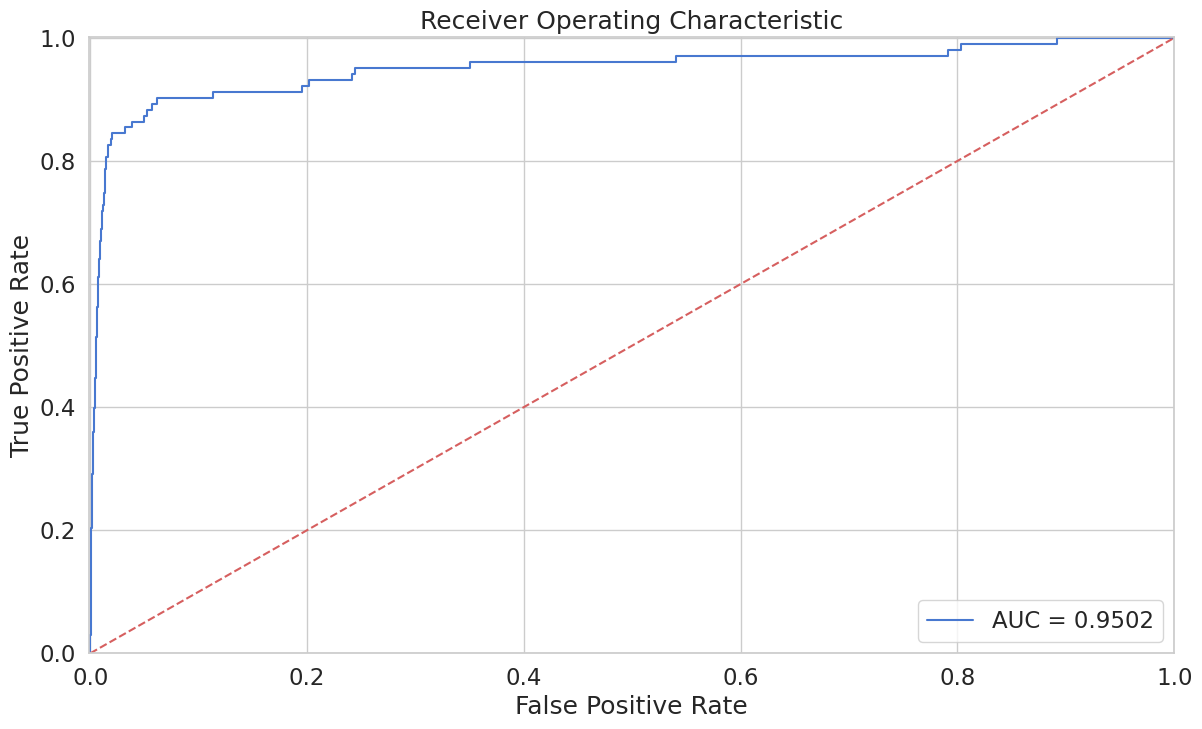

In [36]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

ROC 곡선은 각 기준치(threshold)가 달라질 때마다 '틀린 것을 맞다고 할 확률'(false positive rate)에 따른 '맞는 것을 맞다고 한 확률'(true positive rate)을 그래프로 그린 것입니다. 기본적으로, 파란색 곡선이 왼쪽 위 모퉁이에 가까워질수록 좋습니다. 우리의 결과가 꽤 좋아보이긴 하지만, 우리 데이터가 가진 특징을 염두하고 있어야 합니다. ROC 곡선은 우리에게 그다지 유용해보이진 않네요. 그렇다면..

### 정밀도와 재현율

재현율은 높지만, 정밀도가 낮음

-> 찾은 데이터 수는 많지만, 그 중 실제 찾으려는 대상의 비율은 낮음

정밀도가 높지만, 재현율이 낮음

-> 찾은 데이터 수는 적지만, 그 중 실제 찾으려는 대상의 비율은 높음

이상적으로는, 정밀도와 재현율이 모두 높은 것이 좋음

-> 찾은 데이터 수가 많고, 그 중 실제 찾으려는 대상의 비율이 높음을 의미

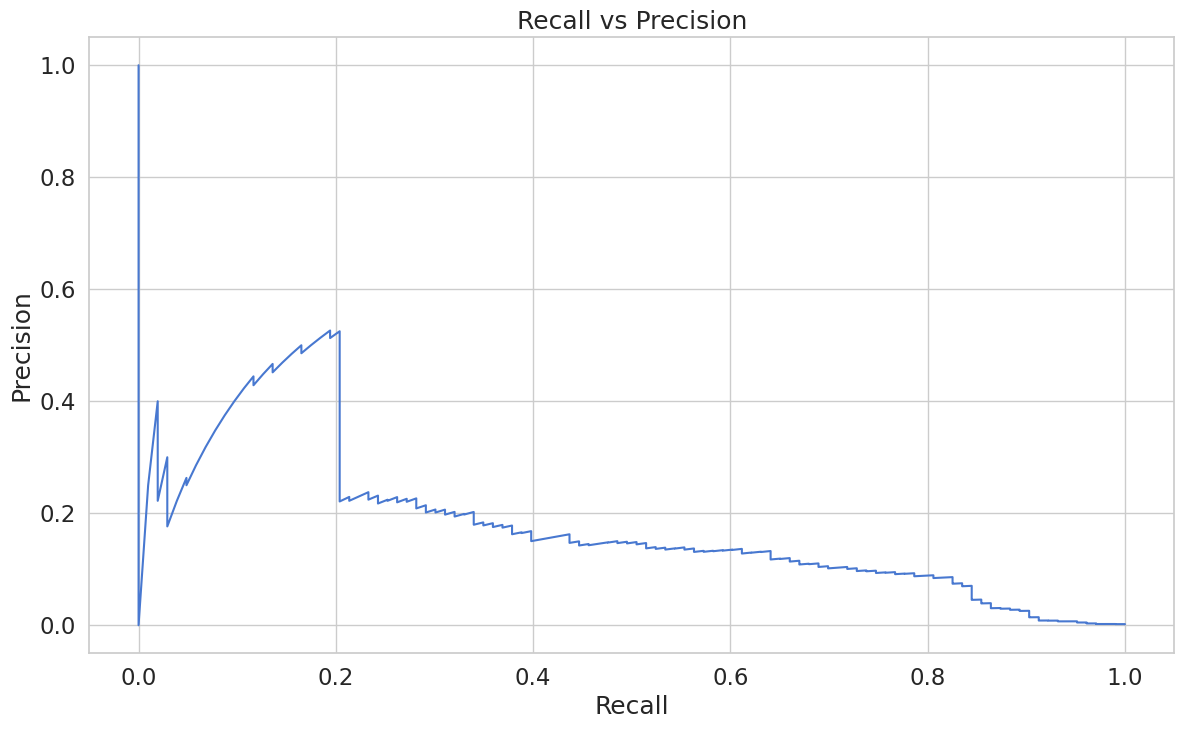

In [37]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

재구성 오류가 증가할수록 정밀도가 올라감

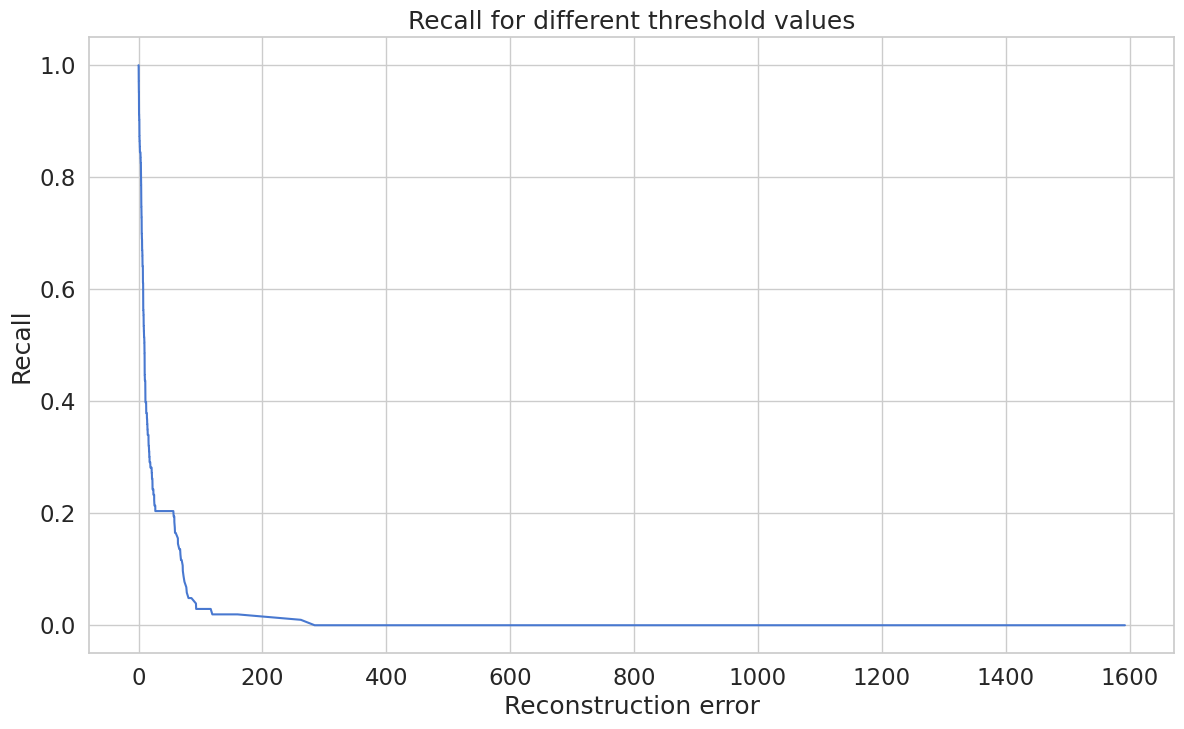

In [38]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

재구성 오류가 증가할수록 재현율은 낮아짐 (반대의 상황)

# 예측하기

이번에는 우리의 모델이 좀 다릅니다. 우리의 모델은 새로운 값을 어떻게 예측해야 하는지 알지 못합니다. 그러나 우리는 그럴 필요가 없죠. 새로운, 본 적 없는 데이터가 정상 거래인지 이상 거래인지 알기 위해서는 그 데이터에서 나온 재구성 오류를 계산하면 됩니다. 만약 오류가 미리 정해놓은 기준치(threshold)보다 크다면, 우리는 그것을 이상거래로 판단합니다.(정상 거래 데이터에서는 우리의 모델이 작은 오류를 가질 것이기 때문에) 그럼 한 번 기준치를 정해볼까요:

그 후 두가지 유형의 거래를 얼마나 잘 나누는지 확인

In [39]:
threshold = 2.9

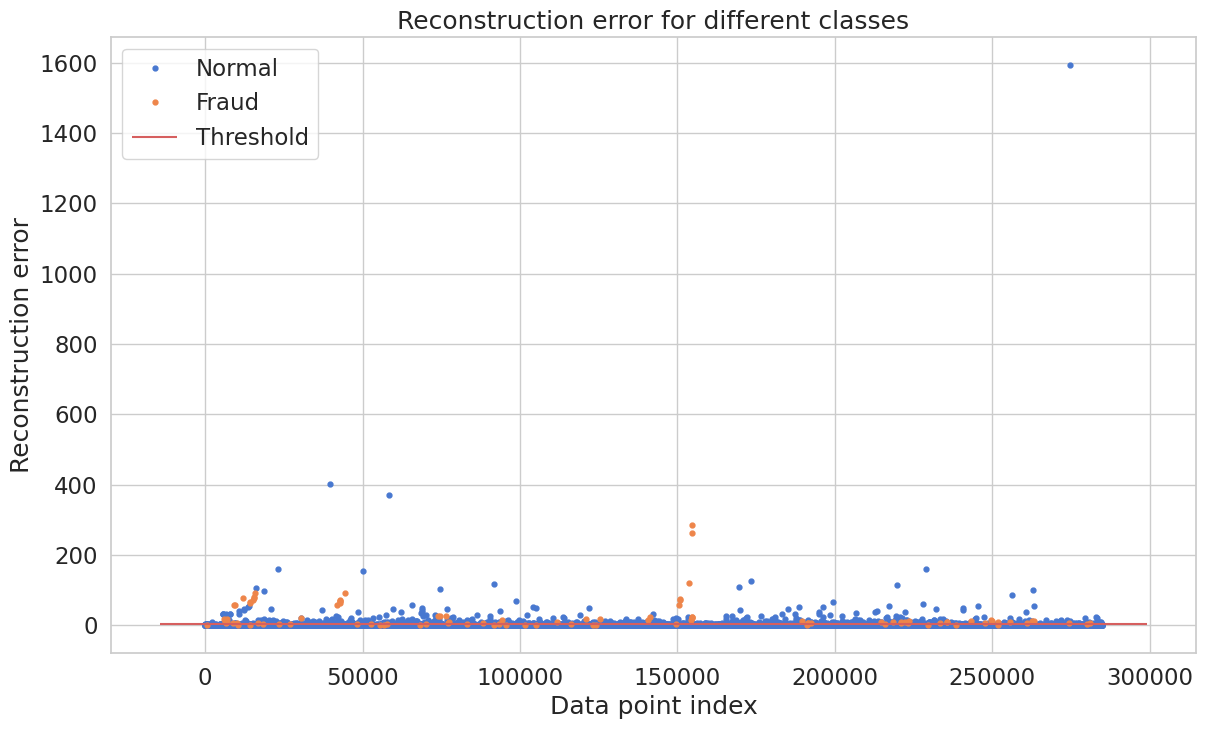

In [40]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

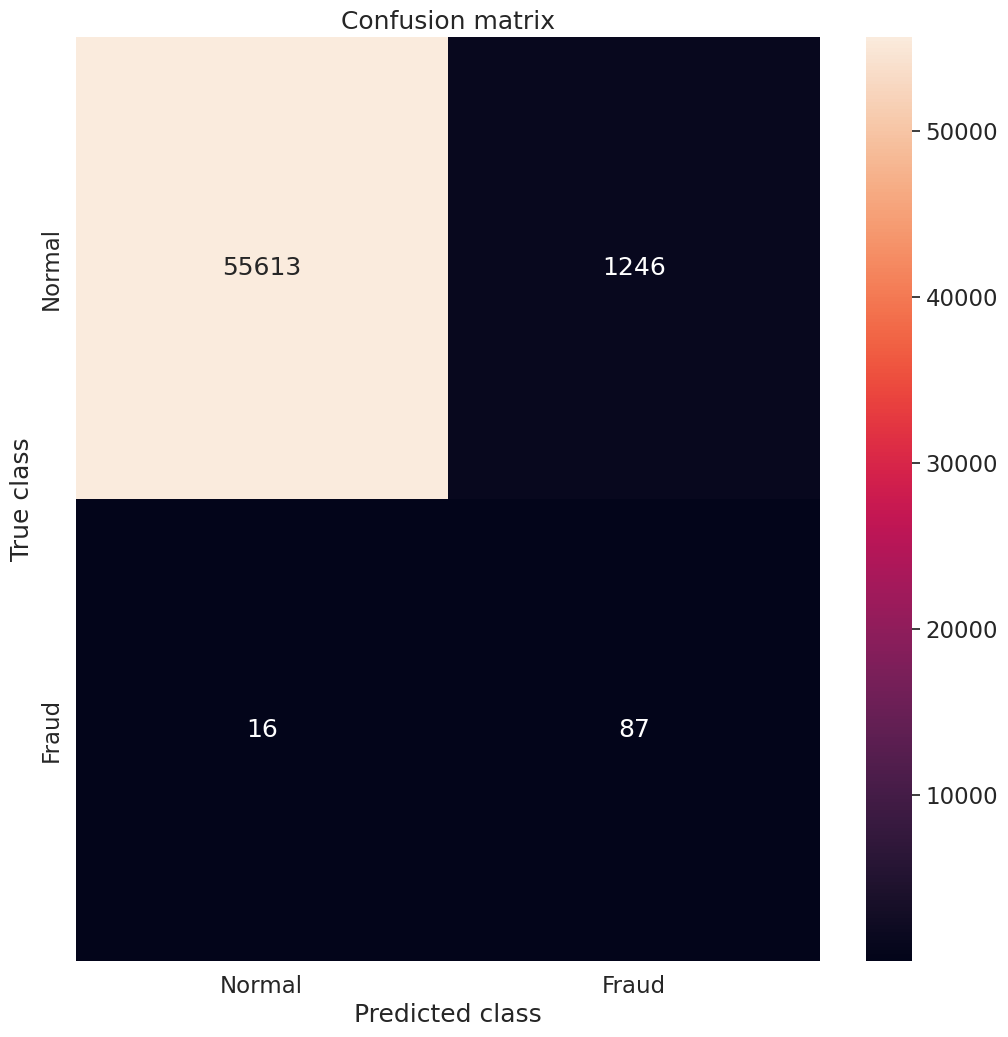

In [41]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()